### Change from V16
- Pseudo round 2
- Pretrain 5k5

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [2]:
!nvidia-smi

Sun Dec 19 08:53:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P0    71W / 300W |  31186MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |  11884MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import torch
torch.__version__

'1.7.1'

In [4]:
# try:
#     import detectron2
# except:
#     !pip install --upgrade pyyaml==5.1
#     !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
#     # !pip install --upgrade albumentations==0.5.2

In [5]:
# import os
# if(not os.path.exists('train/')):
#     !tar -xvf /content/gdrive/MyDrive/Kaggle/Sartorius/data/annotation.tar.gz
#     !unzip /content/gdrive/MyDrive/Kaggle/Sartorius/data/sartorius-cell-instance-segmentation.zip

In [6]:
import sys
sys.path.append('/tf/SartoriusCIS/utils/')
from train_net import Trainer
from general import seed_torch
from metric import metric_calculate, rle_decode, rle_encode, check_overlap, get_masks
seed_torch(67)

In [7]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg, CfgNode
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.modeling.backbone import fpn_resneSt

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [9]:
cfg = get_cfg()
ROOT_FOLDER = '/tf/SartoriusCIS/'
ANN_DIR = f'{ROOT_FOLDER}/data/annotation_semisupervised_round2/annotations'
DATA_DIR = f'{ROOT_FOLDER}/data/annotation_semisupervised_round2/images'
FOLD = 0
cfg.OUTPUT_DIR = f'{ROOT_FOLDER}/namnt54/models/maskrcnn_v21_ResNeSt200_pretrain5k5_pseudo_round2_fold{FOLD}'

In [10]:
# !rm -rf /tf/SartoriusCIS//namnt54/models/maskrcnn_v4.3_ResNeSt200_livecell_shsy5y_fold3/metrics.json

In [11]:
dataDir=Path(DATA_DIR)

cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, f'{ANN_DIR}/train/annotations_train_{FOLD}.json', dataDir)
register_coco_instances('sartorius_val',{}, f'{ANN_DIR}/valid/annotations_valid_{FOLD}.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
valid_ds = DatasetCatalog.get('sartorius_val')

In [14]:
exp = []

/tf/SartoriusCIS/data/annotation_semisupervised_round2/images/shsy5y[diff]_D1-1_Vessel-714_2019-06-15_11h30m00s_Ph_3.png
Found


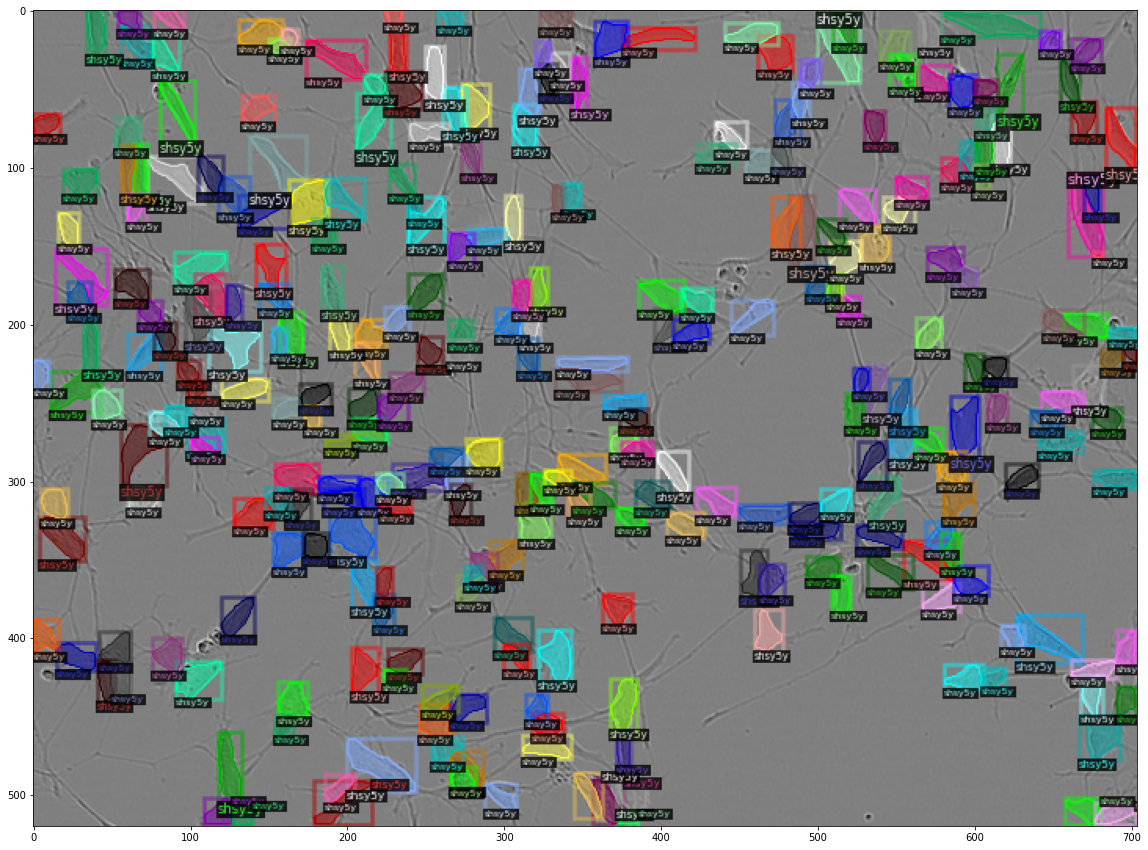

In [23]:
for d in train_ds:
    if 'Vessel' in d['file_name'] and d['file_name'] not in exp and d['annotations'][0]['category_id']==0:
        print(d['file_name'])
        print('Found')
        exp.append(d['file_name'])
        break
# print(d)
# del d['annotations'][0]['segmentation']
# del d['annotations'][0]['bbox_mode']
# d['annotations'][0]['segmentation']['counts'] = 'Po_41W`000001O0O3M2O1O1O100O0000M3O00001000O10O3Mc[Z6'

img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

In [24]:
# d['annotations'][0]

{'file_name': '/tf/SartoriusCIS/data/annotation_semisupervised_round2/images/SHSY5Y_Phase_B10_1_02d20h00m_2.tif', 'height': 520, 'width': 704, 'image_id': '1419467', 'annotations': [{'iscrowd': 0, 'bbox': [412.41, 282.89, 51.36999999999995, 33.5], 'category_id': 0, 'segmentation': {'size': [520, 704], 'counts': 'Z`a6:m?1O1O1N2O1O101O001O1O1O010OEb@L^?2e@NY?2i@MW?2l@LT?2o@No>2SAMm>3TAMj>3XALh>3f0010O01O00010O00100000000O10O1000000000000001O00001O0000[Sj3'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [363.0, 421.65, 9.0, 17.150000000000034], 'category_id': 0, 'segmentation': {'size': [520, 704], 'counts': 'Whh53P`08I6N00000000O3NhUX5'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [370.71, 419.51, 11.580000000000041, 24.00999999999999], 'category_id': 0, 'segmentation': {'size': [520, 704], 'counts': 'nil51V`02N`0A100001O1N1N3N6InRS5'}, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [258.69, 426.43, 10.490000000000009, 9.95999999999998], 'cate

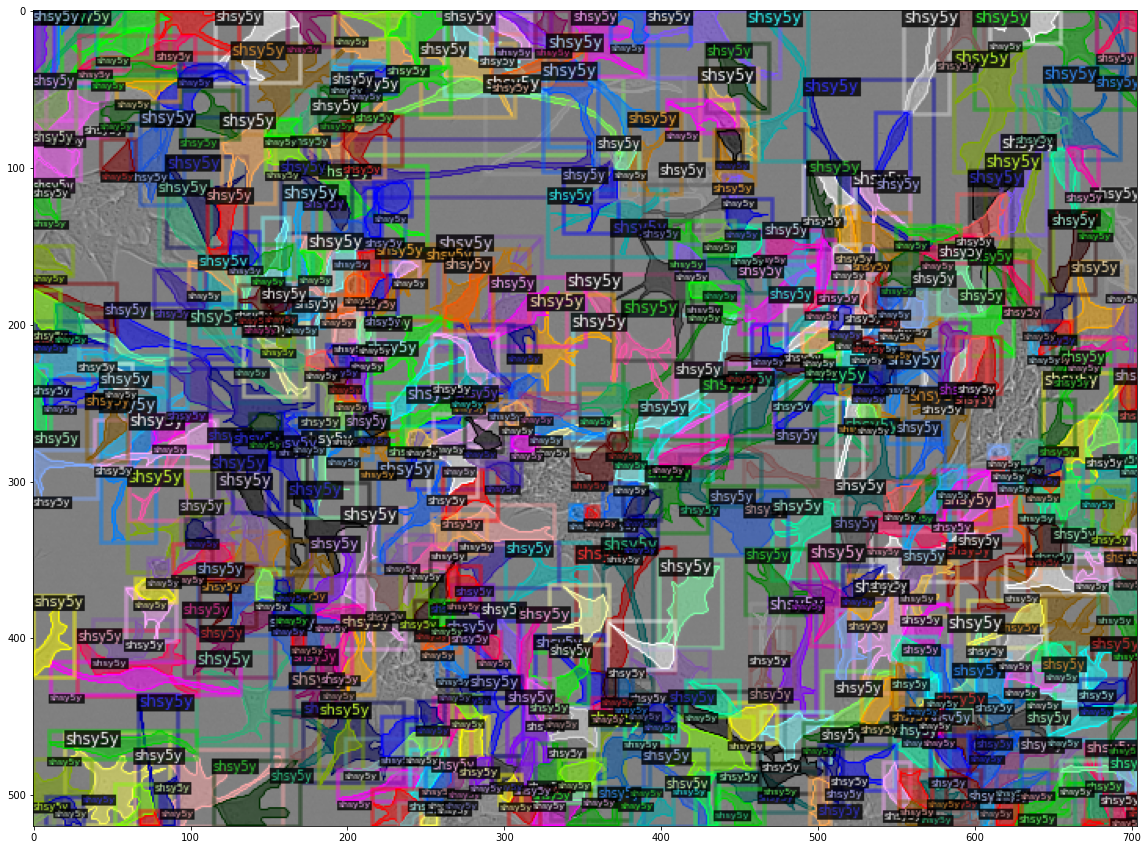

In [25]:
d = train_ds[37]
print(d)
# del d['annotations'][0]['segmentation']
# del d['annotations'][0]['bbox_mode']
# d['annotations'][0]['segmentation']['counts'] = 'Po_41W`000001O0O3M2O1O1O100O0000M3O00001000O10O3Mc[Z6'

img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

In [26]:
# for i, d in enumerate(train_ds):
#     if(d['file_name'].endswith('tif')):
#         print(i)

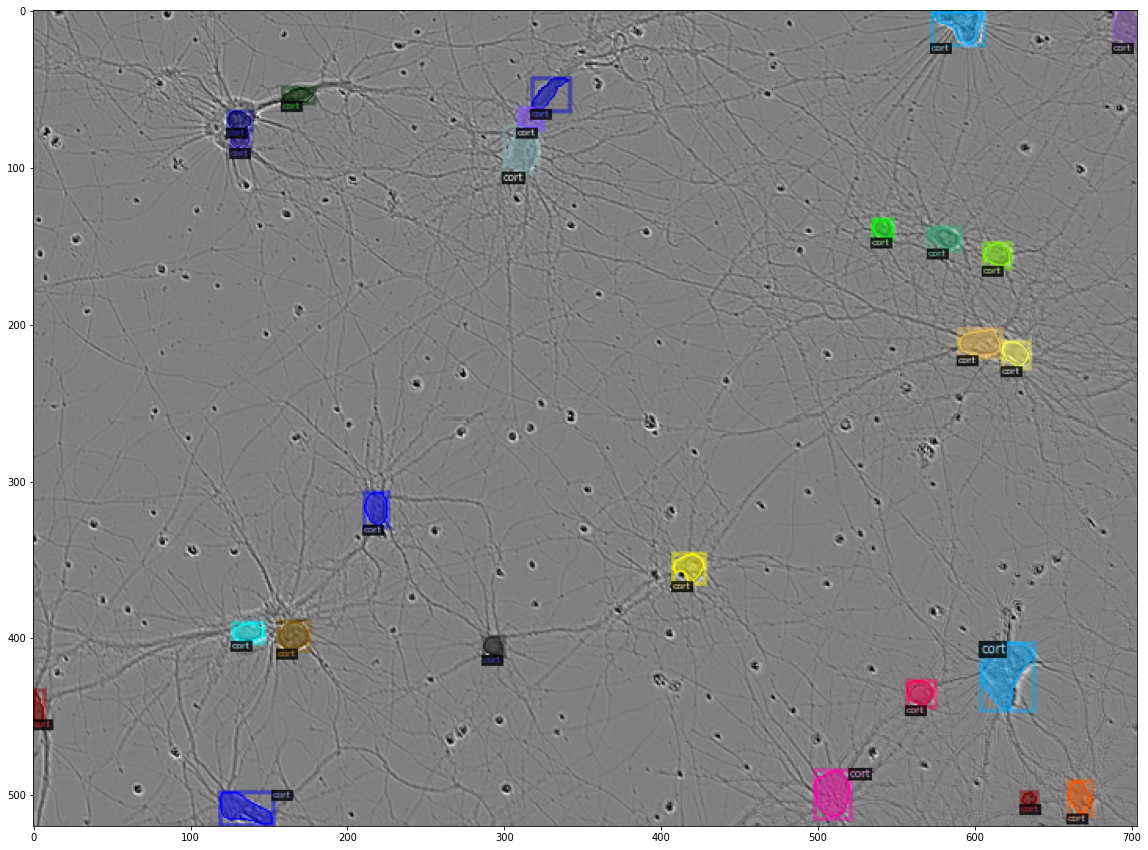

In [27]:
d = valid_ds[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

In [28]:
cfg.MODEL.RESNETS.RADIX = 1
cfg.MODEL.RESNETS.DEEP_STEM = False
cfg.MODEL.RESNETS.AVD = False
# Apply avg_down to the downsampling layer for residual path 
cfg.MODEL.RESNETS.AVG_DOWN = False
cfg.MODEL.RESNETS.BOTTLENECK_WIDTH = 64


cfg.merge_from_file(f"{ROOT_FOLDER}/namnt54/detectron2-ResNeSt-resnest/configs/COCO-InstanceSegmentation/mask_rcnn_ResNeSt200.yaml")
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_train", "sartorius_val")
# cfg.SOLVER.AMP = CfgNode({'ENABLED':True})
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = f'{ROOT_FOLDER}/namnt54/models/maskrcnn_v18_ResNeSt200_livecell_alltypes_pseudo_fold0/model_0033999.pth'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003
cfg.SOLVER.MAX_ITER = 30000    
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
# cfg.TEST.EVAL_PERIOD = len(train_ds) // cfg.SOLVER.IMS_PER_BATCH
cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.STEPS = ( 20000,)        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 1024
cfg.MODEL.RPN.POSITIVE_FRACTION = 0.7

# augment
cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.SIZE = [0.8, 0.8]

# img size
cfg.INPUT.MIN_SIZE_TRAIN = (1024, )
cfg.INPUT.MAX_SIZE_TRAIN = (2000, )
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 2000

cfg.MODEL.BACKBONE.FREEZE_AT = 0

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print('Number of iterations in 1 epoch:', len(train_ds) // cfg.SOLVER.IMS_PER_BATCH)

Number of iterations in 1 epoch: 1536


In [29]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('sartorius_train', 'sartorius_val')
  TRAIN: ('sartorius_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: True
    SIZE: [0.8, 0.8]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 2000
  MAX_SIZE_TRAIN: (2000,)
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN: (1024,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.25, 0.5, 1.0, 2.0, 4.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[4], [9], [17], [31], [64], [127]]
  BACKBONE:
    FREEZE_AT: 0
    NAME: build_resneSt_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURE

In [30]:
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/19 08:56:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (11, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (11,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (11, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (11,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to the model due to incompatible shapes: (11, 1024) in the checkpoint but (4, 1024) 

[12/19 08:57:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/data/detection_utils.py:421: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.6/dist-packages/detectron2/data/detection_utils.py:421: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. T

[12/19 08:58:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdefe018158> to CPU due to CUDA OOM
[12/19 08:58:38 d2.utils.events]:  eta: 1 day, 0:26:50  iter: 19  total_loss: 6.941  loss_cls_stage0: 1.332  loss_box_reg_stage0: 0.3495  loss_cls_stage1: 1.415  loss_box_reg_stage1: 0.7542  loss_cls_stage2: 1.468  loss_box_reg_stage2: 0.8911  loss_mask: 0.6888  loss_rpn_cls: 0.01252  loss_rpn_loc: 0.03894  time: 3.6548  data_time: 0.2837  lr: 5.9943e-06  max_mem: 27089M
[12/19 08:58:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdefe018158> to CPU due to CUDA OOM
[12/19 08:59:48 d2.utils.events]:  eta: 1 day, 1:15:42  iter: 39  total_loss: 7.013  loss_cls_stage0: 1.275  loss_box_reg_stage0: 0.3469  loss_cls_stage1: 1.38  loss_box_reg_stage1: 0.7902  loss_cls_stage2: 1.437  loss_box_reg_stage2: 0.9326  loss_mask: 0.6727  loss_rpn_cls: 0.01615  loss_rpn_loc: 0.06342  time: 3.5712  data_time: 0.1493  lr: 1.1988e-05  max_mem: 2797

In [21]:
aaaaaaaa

NameError: name 'aaaaaaaa' is not defined

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0028999.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.99
cfg.CUSTOM = CfgNode()
cfg.CUSTOM.THRESHOLDS = [0.3,0.5,0.6]
cfg.TEST.DETECTIONS_PER_IMAGE = 10000
cfg.CUSTOM.NMS_THRESH = [0.1,0.1,0.1]

predictor = DefaultPredictor(cfg)

In [ ]:
from postprocessing import post_process_output

In [ ]:
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []

import numpy as np
random.seed(42)

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    outputs = post_process_output(cfg, outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from metric_fast_with_mask_nms import MAPIOUEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset

In [ ]:
%%time
evaluator = MAPIOUEvaluator(cfg, "sartorius_val", thresh_for_each_class=True, resolve_overlap=True)
val_loader = build_detection_test_loader(cfg, "sartorius_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
3309 -> 3319

In [ ]:
import pandas as pd
valid_df = pd.read_csv('valid_meta.csv')
valid_df['AP'] = evaluator.scores
valid_df.groupby('cell').AP.sum()/119

In [ ]:
%%time
cfg.CUSTOM.THRESHOLDS = [0.3,0.6,0.6]
predictor = DefaultPredictor(cfg)

evaluator = MAPIOUEvaluator(cfg, "sartorius_val", thresh_for_each_class=True, resolve_overlap=True)
val_loader = build_detection_test_loader(cfg, "sartorius_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
import pandas as pd
valid_df = pd.read_csv('valid_meta.csv')
valid_df['AP'] = evaluator.scores
valid_df.groupby('cell').AP.sum()/119

In [ ]:
%%time
cfg.CUSTOM.THRESHOLDS = [0.4,0.6,0.7]
predictor = DefaultPredictor(cfg)

evaluator = MAPIOUEvaluator(cfg, "sartorius_val", thresh_for_each_class=True, resolve_overlap=True)
val_loader = build_detection_test_loader(cfg, "sartorius_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
import pandas as pd
valid_df = pd.read_csv('valid_meta.csv')
valid_df['AP'] = evaluator.scores
valid_df.groupby('cell').AP.sum()/119

In [ ]:
ls

In [ ]:
# 111999: 0.3271

In [ ]:
%%time
evaluator = MAPIOUEvaluator(cfg, "sartorius_train", thresh_for_each_class=True, resolve_overlap=True)
val_loader = build_detection_test_loader(cfg, "sartorius_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
ls